In [1]:
import copy
import torch.nn as nn
import torch
from FrEIA.framework import *
from FrEIA.modules import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
device = torch.device("cuda:0")

In [2]:
def get_linear_subnet(N, inp_size, hidden_size, out_size):
    layer_list = []
    layer_list.append(nn.Linear(inp_size, hidden_size))
    layer_list.append(nn.ReLU())
    for i in range(N-1):
        layer_list.append(nn.Linear(hidden_size, hidden_size))
        layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(hidden_size, out_size))
    return nn.Sequential(*layer_list)

def get_conv_subnet(N, inp_size, kernel = 3, stride = 1):
    layer_list = []
    for i in range(N-1):
        layer_list.append(nn.Conv1d(inp_size, inp_size, kernel, stride, device = device, groups = inp_size))
        layer_list.append(nn.ReLU())
    layer_list.append(nn.Conv1d(inp_size, inp_size, kernel, stride, device = device, groups = inp_size))
    return nn.Sequential(*layer_list)

class RNN(nn.Module):
    """"
    combination of convolutions and recurrent nets, used to treat the condition for our cINN beforehand.
    
    
    
    """
    def __init__(self, inp_size, hidden_size = 32, num_conv = 3, num_rnns = 2, lr = 1e-0):
        super(RNN, self).__init__()
        self.inp_size = inp_size
        self.conv = get_conv_subnet(num_conv, inp_size)
        self.rnn = nn.LSTM(inp_size, hidden_size, num_rnns, batch_first = True, bidirectional = True).to(device)
        #self.linear = get_linear_subnet(num_linear, hidden_size*10*2, hidden_size, out_size).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.conv.parameters())) 
        self.params_trainable +=list(filter(
                lambda p: p.requires_grad, self.rnn.parameters()))
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of RNN parameters: {n_trainable}", flush=True)        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
            )        
        
    def forward(self, x):
        x = self.conv(torch.swapaxes(x, 1, 2))
        full, (last, cn) = self.rnn(torch.swapaxes(x,1,2))
        #print(full[:, -1:,:].reshape(full.shape[0], -1).shape)
        return full[:, -1:,:].reshape(full.shape[0], -1)
    
    def get_dim(self):
        return self.forward(torch.randn(1,100,self.inp_size, device = device)).shape[1]
        
    
class cINN(nn.Module):
    """
    cINN baseclass, using cubic spline blocks.
    
    
    """
    
    
    def __init__(self, inp_size, cond_size, num_blocks = 15, sub_layers = 3, sub_width = 128, lr = 5e-3):
        super(cINN, self).__init__()
        constructor_fct = lambda x_in, x_out: get_linear_subnet(sub_layers, 
                                                                x_in,
                                                                x_in,
                                                                x_out)

        block_kwargs = {
                        "num_bins": 60,
                        "subnet_constructor": constructor_fct,
                        "bounds_init": 10,
                        "permute_soft": True
                           }
        inp_size = (inp_size,)        
        nodes = [InputNode(*inp_size, name='inp')]
        cond_node = ConditionNode(*(cond_size,))
        for i in range(num_blocks):
            nodes.append(Node(
                    [nodes[-1].out0],
                    CubicSplineBlock,
                    block_kwargs,
                    conditions = cond_node,
                    name = f"block_{i}",
                    
                ))
        nodes.append(OutputNode([nodes[-1].out0], name='out'))
        nodes.append(cond_node)
        self.model = GraphINN(nodes, verbose=False).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.model.parameters()))
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of cINN parameters: {n_trainable}", flush=True)
        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )
    def forward(self, x, cond = None):
        return self.model(x, c = cond)
    
class Estimator():
    """
    Wrapper for training cINN and RNN at the same time
    """
    def __init__(self, rnn, cinn):
        self.cinn = cinn
        self.rnn = rnn
    def train(self, epochs, xtrain, ytrain, batch_size):
        loss_curve = []
        for epoch in range(epochs):
            epoch_index = np.random.permutation(len(xtrain))
            epoch_losses = 0
            for i in range(len(xtrain)//batch_size):
                xsamps = xtrain[i*batch_size:(i+1)*batch_size]
                ysamps = ytrain[i*batch_size:(i+1)*batch_size]
                self.cinn.optimizer.zero_grad()
                self.rnn.optimizer.zero_grad()
                cond = self.rnn(ysamps)
                gauss, jac = self.cinn(xsamps, cond)
                latent_loss = torch.mean(gauss**2/2) - torch.mean(jac)/gauss.shape[1]
                if latent_loss < 1e30:
                    latent_loss.backward()
                else:
                    print(f"loss is {latent_loss}")
                    return
                self.cinn.optimizer.step()
                self.rnn.optimizer.step()
                epoch_losses += latent_loss.item()/(len(xtrain)//batch_size)
            loss_curve.append(epoch_losses)
            self.cinn.scheduler.step(epoch_losses)
            self.rnn.scheduler.step(epoch_losses)
            print("Epoch:", epoch + 1)
            print("Loss:", epoch_losses)
        plt.plot(np.arange(len(loss_curve)),np.array(loss_curve))
        
    def inference(self, data_point, true_param):  #plot parameter estimates for a time series and the true param
        outputs = []
        for i in range(100):
            gauss = torch.randn(1000,7).to(device)
            cond = self.rnn(data_point.repeat(1000,1,1))
            output, _ = self.cinn(gauss, cond)
            outputs.append(output.detach().cpu())
        output = torch.cat(outputs, dim = 0)
        output = output*stds.cpu()+means.cpu()
        fig, axis = plt.subplots(4,2, figsize = (10,15))
        axis[0,0].hist(output.numpy()[:,0], bins = 100, density = True)
        get_line(axis[0,0], true_param[0])
        axis[0,0].set_title("initial infected")
        axis[0,1].hist(output.numpy()[:,1], bins = 100, density = True)
        get_line(axis[0,1], true_param[1])
        axis[0,1].set_title("populations size")
        axis[1,0].hist(output.numpy()[:,2], bins = 100, density = True)
        get_line(axis[1,0], true_param[2])
        axis[1,0].set_title("contagion distance")
        axis[1,1].hist(output.numpy()[:,3], bins = 100, density = True)
        get_line(axis[1,1], true_param[3])
        axis[1,1].set_title("critical_limit")
        axis[2,0].hist(output.numpy()[:,4], bins = 100, density = True)
        get_line(axis[2,0], true_param[4])
        axis[2,0].set_title("amp_susc")
        axis[2,1].hist(output.numpy()[:,5], bins = 100, density = True)
        get_line(axis[2,1], true_param[5])
        axis[2,1].set_title("amp_rec")
        axis[3,0].hist(output.numpy()[:,6], bins = 100, density = True)
        get_line(axis[3,0], true_param[6])
        axis[3,0].set_title("amp_inf")
        
def get_line(ax, x):
    ax.axvline(x, color = "r")

In [3]:
def load_data(num):
    all_data = []
    all_params = []
    i = 0
    j = 2
    while(len(all_data)<num):
        name_dat = f"F:/data{j}/dat{i}.csv"
        name_param = f"F:/params/params{i}.csv"
        try:
            df_dat = pd.read_csv(name_dat)
            df_param = pd.read_csv(name_param)
            param = df_param.to_numpy()[0,[0,3,4,5,6,7,8]]
            data = df_dat.iloc[:,2].to_numpy().reshape(-1,7)
            if len(data[np.isnan(data)]) == 0:
                all_data.append(data)
                all_params.append(param)
            i += 1
        except:
            i = 0
            j += 1
        if j>8:
            print("not so much data")
            break
        if len(all_data)%1000 == 0:
            print("Loaded",len(all_data),"Entries")
            
    return torch.from_numpy(np.array(all_data)).to(device).to(torch.float32), torch.from_numpy(np.array(all_params)).to(device).to(torch.float32)
data, params = load_data(19000)

means = params.mean(dim = 0)
stds = params.std(dim = 0)
stds[stds==0] = 1
params_normalized = (params-means)/stds

Loaded 1000 Entries
Loaded 2000 Entries
Loaded 3000 Entries
Loaded 4000 Entries
Loaded 5000 Entries
Loaded 6000 Entries
Loaded 7000 Entries
Loaded 8000 Entries
Loaded 9000 Entries
Loaded 10000 Entries
Loaded 11000 Entries
Loaded 12000 Entries
Loaded 13000 Entries
Loaded 14000 Entries
Loaded 15000 Entries
Loaded 16000 Entries
Loaded 17000 Entries
Loaded 18000 Entries
Loaded 19000 Entries


In [10]:
#rnn = RNN(7)
#cinn = cINN(7, rnn.get_dim())

network = Estimator(rnn, cinn)
cond = network.train(1000, params_normalized, data, batch_size = 1000)

Number of RNN parameters: 35668
Number of cINN parameters: 589950
Epoch: 1
Loss: 0.6745779671167073
Epoch: 2
Loss: 0.445530493008463
Epoch: 3
Loss: 0.4153721850169333
Epoch: 4
Loss: 0.39317238487695405
Epoch: 5
Loss: 0.37656770411290624
Epoch: 6
Loss: 0.3602979089084424
Epoch: 7
Loss: 0.3452665821502083
Epoch: 8
Loss: 0.33986401401068034
Epoch: 9
Loss: 0.3282992526104576
Epoch: 10
Loss: 0.3230304012173101
Epoch: 11
Loss: 0.3052317155034919
Epoch: 12
Loss: 0.30479264416192703
Epoch: 13
Loss: 0.29859877573816407
Epoch: 14
Loss: 0.2909170122523056
Epoch: 15
Loss: 0.2861194987046091
Epoch: 16
Loss: 0.27450972481777797
Epoch: 17
Loss: 0.2760209692151922
Epoch: 18
Loss: 0.2660557408081858
Epoch: 19
Loss: 0.24932524405027692
Epoch: 20
Loss: 0.24946779953806023
Epoch: 21
Loss: 0.23840662915455665
Epoch: 22
Loss: 0.2221501477454838
Epoch: 23
Loss: 0.2440915209682364
Epoch: 24
Loss: 0.23518462008551552
Epoch: 25
Loss: 0.19629366774308055
Epoch: 26
Loss: 0.21929517702052465
Epoch: 27
Loss: 0.1956

Epoch: 220
Loss: -0.8011951728870994
Epoch: 221
Loss: -0.8048780152672216
Epoch: 222
Loss: -0.8076283367056597
Epoch: 223
Loss: -0.8063973439367195
Epoch: 224
Loss: -0.8088656946232446
Epoch: 225
Loss: -0.8114294880314878
Epoch: 226
Loss: -0.8082645284502129
Epoch: 227
Loss: -0.8085615666289078
Epoch: 228
Loss: -0.8148478834252608
Epoch: 229
Loss: -0.8202716394474632
Epoch: 230
Loss: -0.8192691520640725
Epoch: 231
Loss: -0.8120114991539403
Epoch: 232
Loss: -0.8096055513934085
Epoch: 233
Loss: -0.815708555673298
Epoch: 234
Loss: -0.820719279740986
Epoch: 235
Loss: -0.8245964175776432
Epoch: 236
Loss: -0.8290577781827826
Epoch: 237
Loss: -0.8276264385173194
Epoch: 238
Loss: -0.8222489670703286
Epoch: 239
Loss: -0.8265599859388252
Epoch: 240
Loss: -0.8281652205868771
Epoch: 241
Loss: -0.8263033157900761
Epoch: 242
Loss: -0.8254424051234596
Epoch: 243
Loss: -0.8300977631619102
Epoch: 244
Loss: -0.8320635964995938
Epoch: 245
Loss: -0.8279998271088851
Epoch: 246
Loss: -0.8320124525772898
Epo

KeyboardInterrupt: 

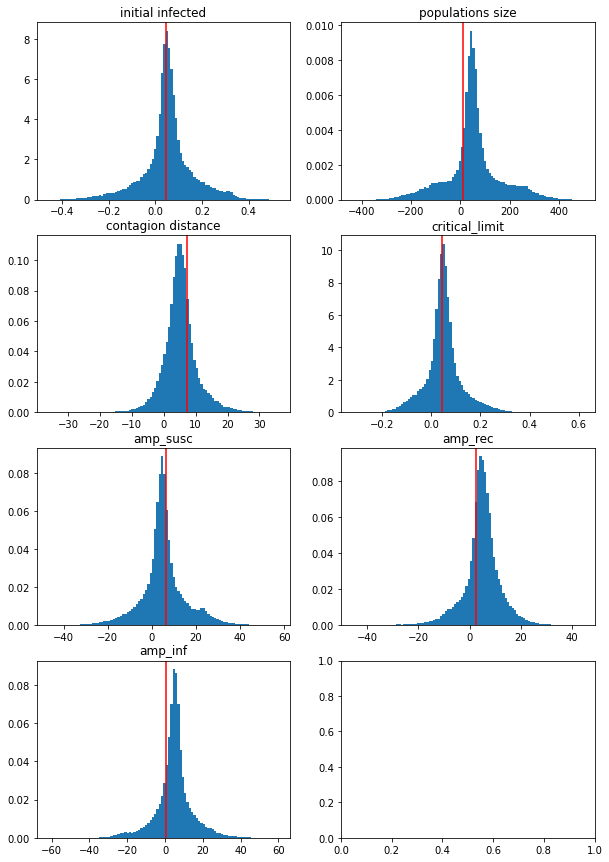

In [5]:
i = 110
network.inference(data[i], params[i])

In [15]:
counts = np.array([0, 881994, 623379, 474861, 340332, 1209080])
eff = np.array([95, 94.9, 95., 94.3, 92.8, 94.5])* 0.01
fact_up = np.zeros(6)
for i in range(6):
    fact_up[i] = counts[i]/np.sum(counts[i+1:])
    
fact_down = np.zeros(6)
for i in range(6):
    fact_down[i] = counts[i]*(1-eff[i])/eff[i]/np.sum(counts[i+1:])
    
print(fact_up)
print(fact_down)

[0.         0.33312308 0.30795204 0.3064782  0.28148013        inf]
[0.         0.01790229 0.016208   0.01852519 0.02183898        inf]


<ipython-input-15-ce78240bd93a>:5: RuntimeWarning: divide by zero encountered in long_scalars
  fact_up[i] = counts[i]/np.sum(counts[i+1:])
<ipython-input-15-ce78240bd93a>:9: RuntimeWarning: divide by zero encountered in double_scalars
  fact_down[i] = counts[i]*(1-eff[i])/eff[i]/np.sum(counts[i+1:])
